## Visualizing results -  Spacy + en_core_web_lang + georesolver

### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def display_geoparser_entities(result):
    for i in result.keys():
        for k in result[i][0:15]:
            ER= k["display_ER"]
            print(" %s -- Clean Text: %s \n" %( k["text_unit id"], k["clean_text"]))
            if ER:
                print(" --> \t %s -- Entities with the Original Geoparser: \n" % k["text_unit id"])
                for ent in ER[2:]:
                    print("%s (p:%s, group:%s)" %(ent[0], ent[1]["p"], ent[1]["group"]), end='', flush=True)
                print("\n")
         

In [5]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [6]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [7]:
def label_freq_places(df_total, df_max_geolocations):
    place_label=[]
    place_freq = []
    for i in range(0,15):
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        print(i, place_count,place_name)
        place_label.append(place_name)
        place_freq.append(place_count)
    return place_label, place_freq

In [8]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color = 'green')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, place_label, rotation=40)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')
    plt.savefig('SpaCy.png', dpi=200)


We run the *georesolution_pages* defoe query over "Descriptive account of the principal towns in Scotland - 1828"* gazetter using the "en_core_web_lang" model (specified in queries/lang_model.yml file) 

    spark-submit --py-files defoe.zip defoe/run_query.py nls-gaz-demo.txt nls defoe.nls.queries.georesolution_pages  queries/lang_model.yml -r georesolution_97350713_en_core_web_lg -n 16
 
Note: We just perfomed this study using all the pages of one book. Therefore, the *nlz-gaz-demo.txt* only has one directory: XXXX/nls-data-gazetteersOfScotland/97350713. But we could run this query using the full dataset (which will include all the directories).

This query does the following tasks:

- Ingests all the pages from the directory "97350713",  which corresponds to the book "Descriptive account of the principal towns in Scotland - 1828"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* running spacy over the cleaned text using the language model specified in lang_model.yml ("en" | "en_core_web_lg")
- From the previous entities, just selects the one about *location* (GPE, LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve (from the Edinburgh Geoparser) to each xml and gets lat and long. 
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: Display of a page’s entities found by SpaCy (in HTML format)
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver to the page’s  locations (GPE|LOC) found by SpaCy
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular gazetter (e.g. 376)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en | en_core_web_lg )
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Gazetter's year 


Example:

    - "Descriptive account of the principal towns in Scotland: to accompany Wood''s town atlas':
        - archive_filename: /home/tdm/datasets/nls-data-gazetteersOfScotland/97350713
          clean_text: "Xll Greenock, 171 Haddington, 181 Hamilton, ..."
          display_doc: "<div class=\"entities\" ... </div>"
          edition: '1828'
          georesolution_page:
            Hawick-1:
                - '55.43087886526603'
                - '-2.783760603318087'
            Inverness-2:
                - '57.47871409771949'
                - '-4.212450527351024'
            Irvine-3:
                - '55.61745277982008'
                - '-4.648988008195091'
            Kilmarnock-4:
                - '55.60786285285697'
                - '-4.4938145618221'
            Kinross-6:
                - '56.20706059952164'
                - '-3.425083589220186'
            Kirkcaldy-5:
                - '56.11807493043916'
                - '-3.164331051156353'
            Lanark-7:
                - '55.67483195471274'
                - '-3.775417694605498'
            Montrose-8:
                - '56.70832370552517'
                - '-2.467117965467635'
            Perth-9:
                - '56.42282247580768'
                - '-3.47920071045354'
            lang_model: en_core_web_lg
          model: nls
          num_text_unit: 376
          page_filename: alto/97350923.34.xml
          place: Edinburgh
          text_unit: page
          text_unit id: Page18
          type_distribution: book
          year: 1828


In [9]:
results=read_query_results('georesolution_97350713_en_core_web_lg')

In [10]:
display_spacy_entities(results)

 
 ----- Page2: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page3: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page4: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page7: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page9: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page10: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page11: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page13: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page14: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page15: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page17: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page18: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page19: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page23: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page24: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page25: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page26: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page27: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page28: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page29: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page30: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page31: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page32: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page33: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page34: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page35: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page36: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page37: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page38: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page39: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page40: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page41: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page42: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page43: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page44: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page45: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page46: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page47: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page48: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page49: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page50: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page51: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page52: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page53: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page54: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page55: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page56: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page57: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page58: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page59: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page60: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page61: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page62: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page63: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page64: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page65: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page66: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page67: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page68: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page69: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page70: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page71: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page72: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page73: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page74: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page75: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page76: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page77: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page78: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page79: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page80: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page81: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page82: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page83: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page84: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page85: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page86: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page87: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page88: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page89: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page90: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page91: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page92: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page93: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page94: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page95: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page96: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page97: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page98: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page99: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page100: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page101: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page102: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page103: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page104: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page105: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page106: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page107: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page108: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page109: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page110: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page111: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page112: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page113: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page114: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page115: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page116: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page117: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page118: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page119: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page120: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page121: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page122: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page123: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page124: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page127: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page128: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page129: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page130: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page131: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page133: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page134: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page135: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page136: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page137: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page138: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page139: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page140: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page141: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page142: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page143: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page144: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page145: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page146: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page147: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page148: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page149: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page151: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page152: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page153: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page154: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page155: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page157: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page158: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page159: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page160: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page161: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page162: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page163: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page164: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page165: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page166: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page167: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page169: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page170: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page171: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page172: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page173: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page174: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page175: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page176: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page177: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page178: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page179: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page180: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page181: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page182: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page183: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page184: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page185: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page186: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page187: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page188: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page189: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page190: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page191: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page193: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page194: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page195: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page196: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page197: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page198: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page199: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page201: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page202: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page203: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page204: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page205: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page206: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page207: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page208: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page209: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page210: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page211: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page213: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page214: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page215: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page216: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page217: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page219: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page220: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page221: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page222: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page223: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page225: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page226: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page227: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page228: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page229: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page230: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page231: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page233: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page234: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page235: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page236: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page237: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page238: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page239: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page240: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page241: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page242: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page243: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page245: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page246: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page247: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page248: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page249: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page251: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page252: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page253: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page254: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page255: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page256: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page257: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page258: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page259: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page260: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page261: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page262: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page263: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page264: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page265: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page266: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page267: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page269: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page270: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page271: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page272: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page273: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page274: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page275: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page276: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page277: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page278: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page279: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page280: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page281: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page282: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page283: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page284: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page285: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page286: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page287: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page288: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page289: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page290: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page291: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page293: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page294: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page295: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page296: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page297: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page299: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page300: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page301: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page302: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page303: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page304: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page305: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page306: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page307: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page308: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page309: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page310: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page311: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page313: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page314: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page315: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page316: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page317: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page319: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page320: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page321: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page322: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page323: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page324: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page325: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page326: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page327: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page328: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page329: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page330: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page331: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page332: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page333: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page335: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page336: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page337: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page338: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page339: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page340: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page341: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page342: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page343: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page344: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page345: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page346: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page347: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page348: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page349: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page350: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page351: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page353: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page354: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page355: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page356: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page357: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page358: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page359: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page360: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page361: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page362: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page363: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page364: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page365: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page367: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page368: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page369: Entities with the Spacy "en_core_web_lg" language model  ----- 



 
 ----- Page370: Entities with the Spacy "en_core_web_lg" language model  ----- 



In [11]:
df_total= geresolution_dataframe(results)

In [12]:
df_total

Latitude            Longitude        Place     Page
0      55.9251525946208   -3.284768133955424    EDINBURGH    Page7
1     51.03264752792496  -0.8961507233247615     PRINCE'S    Page7
2       54.925602546184   -3.054776859855099        Burgh    Page9
3     53.69180622064813   -2.423529257645026     Scotland    Page9
4     49.05597239846705   -122.3211206671363   Abbotsford   Page13
5     55.99177299545033   -5.819896999002346       Argyll   Page13
6     52.29220631718938  -0.2199466502719805        Cluny   Page14
7     -34.5521559886793    -58.4808468818665          Esq   Page14
8            43.9748009          -69.6633795      Hillton   Page14
9     56.05595568929728   -2.727932475832167      Berwick   Page17
10     55.9251525946208   -3.284768133955424    Edinburgh   Page17
11    55.47821605083645   -4.613537156584385          Ayr   Page17
12    57.66476319293115   -2.525850791428574        Banff   Page17
13    56.48922669130275   -2.960382249351255       Dundee   Page17
14    57.15956045188484   -2.134722052407824     Aberdeen   Page17
15    55.07234193735884    -3.60680066213674     Dumfries   Page17
16    55.86214248820098   -4.246499019214728      Glasgow   Page17
17    57.64555477355096   -3.316752816442518        Elgin   Page17
18    56.70832370552517   -2.467117965467635     Montrose   Page18
19    55.43087886526603   -2.783760603318087       Hawick   Page18
20    55.67483195471274   -3.775417694605498       Lanark   Page18
21    56.11807493043916   -3.164331051156353    Kirkcaldy   Page18
22    55.61745277982008   -4.648988008195091       Irvine   Page18
23    56.42282247580768    -3.47920071045354        Perth   Page18
24    56.20706059952164   -3.425083589220186      Kinross   Page18
25    57.47871409771949   -4.212450527351024    Inverness   Page18
26    55.60786285285697     -4.4938145618221   Kilmarnock   Page18
27    57.15956045188484   -2.134722052407824     ABERDEEN   Page19
28     55.9251525946208   -3.284768133955424    EDINBURGH   Page19
29    57.15956045188484   -2.134722052407824     Aberdeen   Page23
...                 ...                  ...          ...      ...
1425  56.42282247580768    -3.47920071045354        Perth  Page361
1426  56.96954825219983   -2.207221101689155   Stonehaven  Page362
1427  56.96050618989092   -2.240058110156074   Fetteresso  Page362
1428  56.96590381553843    -2.21754202999286   Stonehaven  Page362
1429  56.96590381553843    -2.21754202999286   Stonehaven  Page363
1430  57.68633318560074    -4.96890721218449     Scotland  Page363
1431  56.42282247580768    -3.47920071045354        Perth  Page363
1432  57.15956045188484   -2.134722052407824     Aberdeen  Page363
1433  56.96590381553843    -2.21754202999286   Stonehaven  Page363
1434  56.96590381553843    -2.21754202999286   Stonehaven  Page363
1435  56.96590381553843    -2.21754202999286   Stonehaven  Page365
1436  56.96590381553843    -2.21754202999286   Stonehaven  Page365
1437  56.33466441277253   -3.238902970263289        Thane  Page365
1438  58.08637418657569   -6.884017939304623         Loch  Page367
1439        -16.0666667                123.4    Longitude  Page367
1440  51.91761582836084   -2.575716881120409         Ross  Page367
1441  53.29178959773114   -3.731904990226901          Bay  Page367
1442        -34.0833333                  118        shire  Page367
1443  45.26764557499408   -79.08598792226002         Bays  Page368
1444         42.9339792   -70.79838549999999  north Beach  Page368
1445         42.5153725          -71.1144984     Scotland  Page368
1446  64.35748932499408   -121.9272049632756        Birch  Page369
1447   61.1748450791796   -149.8499046498412    anchorage  Page369
1448         43.5220128   -73.50761319999999    South Bay  Page369
1449  52.55062988560678    1.105539635730294         Bays  Page369
1450  58.24568165804411   -6.270516819262197    Broad Bay  Page369
1451  57.58613586344733   -6.360262703281945          Uig  Page369
1452   55.9251525946208   -3.284768133955424    Edinburgh  Pag

In [13]:
df_total[["Place"]].count()

Place    1455
dtype: int64

In [14]:
df_total.sum()

Latitude     55.925152594620851.0326475279249654.9256025461...
Longitude    -3.284768133955424-0.8961507233247615-3.054776...
Place        EDINBURGHPRINCE'SBurghScotlandAbbotsfordArgyll...
Page         Page7Page7Page9Page9Page13Page13Page14Page14Pa...
dtype: object

In [15]:
df_total.groupby("Place").count()

Latitude  Longitude  Page
Place                                       
7 west                    1          1     1
ABERDEEN                  2          2     2
AYR                       1          1     1
Abbotsford                1          1     1
Aberdeen                 39         39    39
Abernethy                 1          1     1
Airdrie                   1          1     1
Albany                    3          3     3
Ale                       1          1     1
Alloa                     3          3     3
America                   8          8     8
Angus                     4          4     4
Annan                     1          1     1
Annandale                 5          5     5
Anstruther                1          1     1
Arbroath                  5          5     5
Argyll                    1          1     1
Arran                     3          3     3
Athol                     3          3     3
Atlantic                  1          1     1
Auchterarder              1          1     1
Avon                      1          1     1
Ayr                      30         30    30
Ayrshire                  4          4     4
BANFF                     1          1     1
Bailies                   5          5     5
Baltic                    3          3     3
Banff                    21         21    21
Banffshire                1          1     1
Bannockburn               1          1     1
...                     ...        ...   ...
anchorage                 3          3     3
baptist                   3          3     3
dosses                    1          1     1
earth                     2          2     2
east                      5          5     5
hill                      1          1     1
massy                     1          1     1
new County                1          1     1
north Beach               1          1     1
north east                2          2     2
north west                1          1     1
regency                   1          1     1
sandy beach               1          1     1
shire                     1          1     1
south                     1          1     1
south east                1          1     1
south west                1          1     1
the Bay                   2          2     2
the Castle Hill           2          2     2
the High Street           6          6     6
the Isle of Wight         1          1     1
the Kingdom               1          1     1
the Old Town              1          1     1
the U U                   1          1     1
the Virgin Mary           1          1     1
the West Indies           2          2     2
the south east            2          2     2
unitarian                 1          1     1
valley                    2          2     2
west                     18         18    18

[399 rows x 3 columns]

In [16]:
df_total.groupby("Page").count()

Latitude  Longitude  Place
Page                               
Page100         7          7      7
Page101         5          5      5
Page102         5          5      5
Page105         9          9      9
Page106         4          4      4
Page107         3          3      3
Page108         9          9      9
Page109         2          2      2
Page110         6          6      6
Page111         7          7      7
Page112         4          4      4
Page113         4          4      4
Page114         7          7      7
Page115         1          1      1
Page116         5          5      5
Page117         7          7      7
Page119         8          8      8
Page120         4          4      4
Page121         3          3      3
Page123         2          2      2
Page124         6          6      6
Page127         9          9      9
Page128         3          3      3
Page129         2          2      2
Page13          2          2      2
Page131         1          1      1
Page133        11         11     11
Page134         6          6      6
Page135         8          8      8
Page136         3          3      3
...           ...        ...    ...
Page69          3          3      3
Page7           2          2      2
Page70         10         10     10
Page71         13         13     13
Page72         13         13     13
Page73          6          6      6
Page75          8          8      8
Page76          4          4      4
Page77          4          4      4
Page78          3          3      3
Page79          1          1      1
Page80          4          4      4
Page81          6          6      6
Page82          7          7      7
Page83          2          2      2
Page84          1          1      1
Page85          8          8      8
Page86          5          5      5
Page88          6          6      6
Page89          3          3      3
Page9           2          2      2
Page90          4          4      4
Page91          1          1      1
Page92          5          5      5
Page93          2          2      2
Page94          2          2      2
Page96          7          7      7
Page97          4          4      4
Page98          1          1      1
Page99          4          4      4

[300 rows x 3 columns]

In [17]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude           Longitude                         
-16.0666667        123.4                      4     4
-16.4862           145.4672                   1     1
-20.29607512813092 149.0036727222712          1     1
-21.76168181758405 -58.16576087147877         2     2
-23.5166667        27.8333333                 1     1
-27.8666667        27.8833333                 1     1
-28.17414587733241 153.5187788053949          1     1
-29.3166667        30.4166667                 1     1
-31.92218148167947 115.8886165711112          8     8
-32.2166667        152.5666667                2     2
-32.82970122618059 147.3155355165509          1     1
-32.96028757093655 151.7271525413066          2     2
-34.0833333        118                        1     1
-34.5521559886793  -58.4808468818665          1     1
-37.1833333        142.5                      1     1
-37.2              143.95                     1     1
-37.769063816073   175.2585844261665          1     1
-38.2              141.35                     1     1
-44.2333333        168.7                      1     1
-44.308346017      169.460080292              1     1
-53.07712087006058 73.5408130292125           2     2
-54.42127655030882 3.416772908307422          2     2
-56.46479522720659 -34.17872300238145         1     1
-73.71575855905536 -106.5906975980731         2     2
-82.61809661250592 -52.80949866444752         1     1
0.6827759806286053 -5.02015397151682          1     1
1.3372222          103.6502778                1     1
10.34006684016259  -2.144488898393888         6     6
10.65684336992561  -61.52036078532194         2     2
10.66958161055304  -61.46726325137568         1     1
...                                         ...   ...
57.6792308206564   -4.03340769925421          1     1
57.68088966695904  -4.03921090250278          1     1
57.68633318560074  -4.96890721218449         35    35
57.6898032661157   -2.819589762353475         1     1
57.80655983371513  -4.046300656397848         1     1
57.8333333         -4.6                       1     1
57.87310841691706  -4.353615950859404         1     1
57.87890991275912  -4.016679137189285         1     1
58.08637418657569  -6.884017939304623         1     1
58.24568165804411  -6.270516819262197         1     1
58.48344685928507  3.75388411453153           2     2
58.84901536003974  -2.908785146314733         1     1
59.02606301635264  -3.44685481331173          2     2
59.0263243784396   -3.094610885633094         1     1
59.22022125858783  25.35590660898998         10    10
6.456079107914547  -58.09417456705259         1     1
60.57977936405658  -140.4120377269475         2     2
61.1748450791796   -149.8499046498412         3     3
61.5255221562841   0.0006248371522588059      2     2
62.39260101365116  -96.81073980772135         1     1
62.82144806522845  -122.3799027171819         1     1
64.35748932499408  -121.9272049632756         1     1
69.25              -141.5                     1     1
69.46820724542312  -139.4637648748779         1     1
69.499676275       -138.00541674              1     1
7.068186448296018  -10.99525356704842         1     1
71.71309153273188  -42.21630733264143         1     1
73.00414887154459  159.1853536318312          2     2
74.27255982125669  -7.034332546405324         1     1
8.995265204296388  -79.47305410790867         2     2

[501 rows x 2 columns]

In [18]:
df_max_geolocations= df_total[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     


df_max_geolocations.head(15)

Place  count
318   Scotland    121
113  Edinburgh    102
145    Glasgow     73
4     Aberdeen     39
282      Perth     36
229     London     31
22         Ayr     30
103     Dundee     25
183  Inverness     23
116    England     23
27       Banff     21
150   Greenock     20
186     Irvine     20
115      Elgin     19
100   Dumfries     18

In [19]:
#Getting the 15 places (and their frequencies) most mentioned
place_label= df_max_geolocations['Place'].tolist()[0:15]
place_freq= df_max_geolocations['count'].tolist()[0:15]
place_freq

[121, 102, 73, 39, 36, 31, 30, 25, 23, 23, 21, 20, 20, 19, 18]

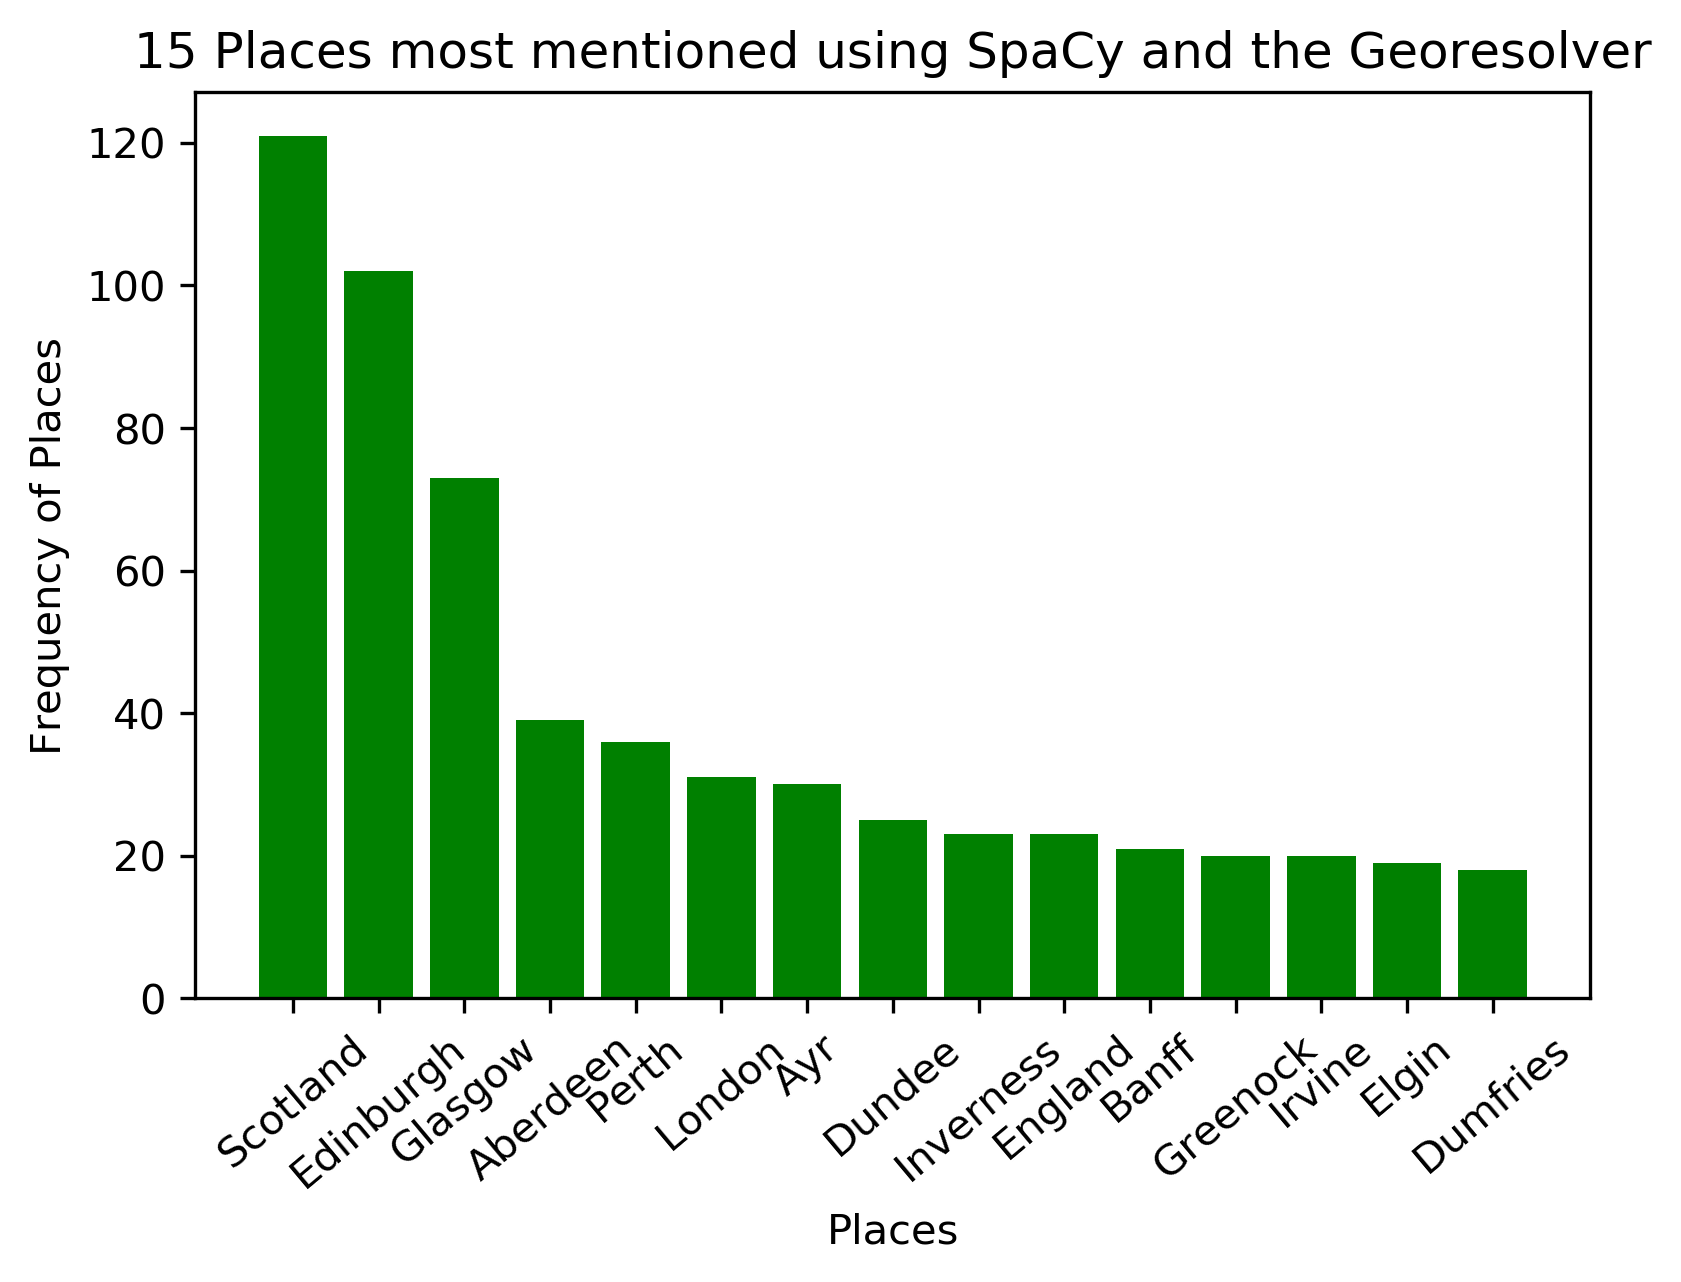

In [20]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)